# DQN Implementation on BREAKOUT game.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install box2d-py
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

    100% |████████████████████████████████| 450kB 20.7MB/s 


### 1. Import the Necessary Packages

In [0]:
import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import pickle

%matplotlib inline

def show_video(folder):
    mp4list = glob.glob('%s/*.mp4' % folder)
    if len(mp4list) > 0:
        encoded = base64.b64encode(io.open(mp4list[0], 'r+b').read())
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;"> 
        <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))))
        
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

###2. Try the Breakout game.

The Breakout game chosen here just returns the RAM, which is 128-dim.

In [0]:
atari_game = "Breakout-ram-v0"
env = gym.wrappers.Monitor(gym.make(atari_game), 'sample', force=True)
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

state = env.reset()
cr = 0
for j in range(2000):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    cr += reward
    print('\r %.5f' % cr, end="")
    if done:
        break 
env.close()
show_video('sample')

State shape:  (128,)
Number of actions:  4
 0.00000

### 3. Building the classes.

The code I used here is based on the reference: https://github.com/plopd/deep-reinforcement-learning.

It contains class QNetwork, Agent and ReplayBuffer.

QNetwork: The fully connected network structures built here.

Agent: The agent used to play the game, save the memory, train the network.

ReplayBuffer: Used to save and push the memory.

In [0]:
BUFFER_SIZE = int(10e5)  # replay buffer size
BATCH_SIZE = 32        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.00005               # learning rate 
UPDATE_EVERY = 8       # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=1028, fc2_units=1028):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.fc1_size = fc1_units
        self.fc2_size = fc2_units
        
        self.fc1 = nn.Linear(self.state_size,self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size,self.fc2_size)
        self.fc3 = nn.Linear(self.fc2_size,self.fc2_size)
        self.fc4 = nn.Linear(self.fc2_size,self.fc2_size)
        self.fc5 = nn.Linear(self.fc2_size,self.action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        a = self.fc1(state)
        a = F.relu(a)
        a = self.fc2(a)
        a = F.relu(a)
        a = self.fc3(a)
        a = F.relu(a)
        a = self.fc4(a)
        a = F.relu(a)
        a = self.fc5(a)
        
        return a

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.policy_network = QNetwork(self.state_size,self.action_size,seed).to(device)
        self.target_network = QNetwork(self.state_size,self.action_size,seed).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.steps = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state, done)
        
        self.steps = (self.steps + 1) % UPDATE_EVERY
        if self.steps == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.policy_network.eval()
        with torch.no_grad():
            actions = self.policy_network(state)
        
        self.policy_network.train()
        
        if random.random() > eps:
            return np.argmax(actions.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # get targets
        self.target_network.eval()
        with torch.no_grad():
            targets_next = torch.max(self.target_network.forward\
                                       (next_states), dim=1, keepdim=True)[0]

        Q_targets = rewards + (GAMMA * targets_next * (1 - dones))

        # get outputs
        self.policy_network.train()
        Q_expected = self.policy_network.forward(states).gather(1, actions)

        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # clear gradients
        self.optimizer.zero_grad()

        # update weights local network
        loss.backward()

        # take one SGD step
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        for target_param,policy_param in \
        zip(self.target_network.parameters(),self.policy_network.parameters()):
            target_param.data.copy_(TAU * policy_param.data + \
                                    (1.0 - TAU) * target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=\
                                     ["state", "action", "reward", \
                                      "next_state", "done"])
        self.seed = random.seed(seed)    
    
    def push(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if \
                                             e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if \
                                             e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if \
                                             e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in \
                                                  experiences if e is \
                                                  not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences \
                                            if e is not None]).astype\
                                 (np.uint8)).float().to(device)
        
        return(states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

**Loading preivious memories with reward higher than 0**

In [0]:
import dill
load_dir = '/content/drive/My Drive/Colab Notebooks/231b/BreakOut/score_memory9.pkl'

# Load the previous score and the memory
with open(load_dir, 'rb') as f:
    score_memory = dill.load(f)
memory1 = score_memory[1]

# Find out the memories with reward > 1
reward1 = [memory1.memory[i][2] for i in range(len(memory1.memory))]
idx1 = [i for i in range(len(reward1)) if reward1[i] > 0]

mems = deque(maxlen=BUFFER_SIZE)
for i in range(len(idx1)):
    mems.append(memory1.memory[idx1[i]])

# Load memory into the replaybuffer
memory = ReplayBuffer(4, BUFFER_SIZE, BATCH_SIZE, 0)
memory.memory = mems

**Training process**

Episode 0	Average Score: 0.00

Episode 0	Average Score: 0.00
Episode 100	Average Score: 1.62

Episode 100	Average Score: 1.62
Episode 200	Average Score: 2.27

Episode 200	Average Score: 2.27
Episode 300	Average Score: 4.37

Episode 300	Average Score: 4.37
Episode 400	Average Score: 15.53

Episode 400	Average Score: 15.53
Episode 500	Average Score: 23.65

Episode 500	Average Score: 23.65
Episode 600	Average Score: 29.30

Episode 600	Average Score: 29.30
Episode 700	Average Score: 29.69

Episode 700	Average Score: 29.69
Episode 800	Average Score: 30.09

Episode 800	Average Score: 30.09
Episode 831	Average Score: 32.01
Environment solved in 731 episodes!	Average Score: 32.01


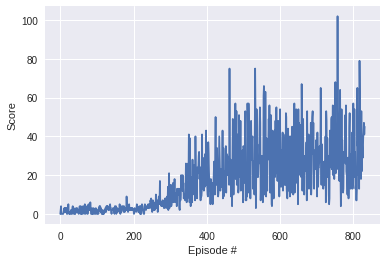

In [0]:
def train(n_episodes=2000, max_t=10000, eps_start=1, eps_end=0.1, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    env = gym.wrappers.Monitor(gym.make(atari_game), 'output', force=True)
    
    agent = Agent(state_size=128, action_size=4, seed=0)
    agent.policy_network.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/231b/BreakOut/checkpoint10.pth'))
    agent.memory = memory
    
    render = True
    for i_episode in range(0, n_episodes):
        if render and i_episode % 100 == 0:
            env = gym.wrappers.Monitor(gym.make(atari_game), 'output_%d' % i_episode, force=True)
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            if render and i_episode % 100 == 0:
                env.render()
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            if render:
                env.close()
                show_video('output_%d' % i_episode)
                env = gym.make(atari_game)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=32.0: # You can change for different game
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
      
    torch.save(agent.policy_network.state_dict(),'/content/drive/My Drive/Colab Notebooks/231b/BreakOut/checkpoint11.pth')
    
    return scores,agent.memory

scores,memory = train(n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

**Save the memory to a local file**

In [0]:
import dill
save_dir = '/content/drive/My Drive/Colab Notebooks/231b/BreakOut/score_memory10.pkl'
dill.dump([scores,memory], open(save_dir, 'wb'))

**Use the trained network to simulate games and show the one with highest score**

In [0]:
policy_network = QNetwork(128,4,0).to(device)
policy_network.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/231b/BreakOut/checkpoint11.pth'))

def act(state, eps=0.):
    """Returns actions for given state as per current policy.
        
    Params
    ======
    state (array_like): current state
    eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    policy_network.eval()
    with torch.no_grad():
       actions = policy_network(state)
        
    if random.random() > eps:
        return np.argmax(actions.cpu().data.numpy())
    else:
        return random.choice(np.arange(4))

eps = 0.1
score = 0
scs = []
for i in range(100):
    env = gym.wrappers.Monitor(gym.make(atari_game), 'Good Score_%d'%i, force=True)
    state = env.reset()
    score = 0
    for t in range(10000):
        action = act(state, eps)
        env.render()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        score += reward
        if done:
            break
    print(i+1,'th round is done, score is ',score)
    scs.append(score)
env.close()
idx = np.argmax(scs)
show_video('Good Score_%d'%idx)

1 th round is done, score is  34.0
2 th round is done, score is  50.0
3 th round is done, score is  22.0
4 th round is done, score is  56.0
5 th round is done, score is  65.0
6 th round is done, score is  35.0
7 th round is done, score is  22.0
8 th round is done, score is  14.0
9 th round is done, score is  49.0
10 th round is done, score is  46.0
11 th round is done, score is  51.0
12 th round is done, score is  23.0
13 th round is done, score is  2.0
14 th round is done, score is  37.0
15 th round is done, score is  26.0
16 th round is done, score is  48.0
17 th round is done, score is  33.0
18 th round is done, score is  44.0
19 th round is done, score is  42.0
20 th round is done, score is  33.0
21 th round is done, score is  35.0
22 th round is done, score is  23.0
23 th round is done, score is  22.0
24 th round is done, score is  21.0
25 th round is done, score is  21.0
26 th round is done, score is  24.0
27 th round is done, score is  43.0
28 th round is done, score is  21.0
29